Load in Data from .mat files

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import get_high_gamma_data

In [2]:
hg_trace, hg_map, phon_labels = get_high_gamma_data('data/S14/S14_HG.mat')

(149, 200, 111)
(149, 8, 16, 200)
(149, 3)


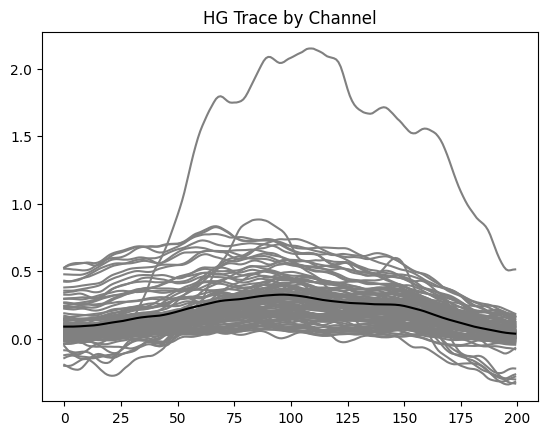

In [3]:
print(hg_trace.shape)
print(hg_map.shape)
print(phon_labels.shape)

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1D CNN Bidirectional LSTM seq2seq

In [4]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [5]:
# parameters
n_output = 10

In [6]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

In [7]:
print(X.shape, X_prior.shape, y.shape, prior_labels.shape, seq_labels.shape)

(149, 200, 111) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [8]:
# imports
from seq2seq_models.rnn_models import lstm_1Dcnn_model


In [9]:
# parameters
n_input_time = X.shape[1]
n_input_channel = X.shape[2]
n_filters = 100
filter_size = 10
n_units = 800
reg_lambda = 1e-6
bidir = False

In [10]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [11]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 111)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 100)      111100      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    5486410     ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

Train Model

In [12]:
# imports
from keras.optimizers import Adam
from train.train import train_seq2seq_kfold

In [13]:
# parameters
num_folds = 10
batch_size = 32
epochs = 1
learning_rate = 1e-3

In [14]:
train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
models, histories, y_pred_all, y_test_all = train_seq2seq_kfold(train_model, inf_enc, inf_dec, X, X_prior, y, num_folds=num_folds, batch_size=batch_size, epochs=epochs)

1/1 [==============================] - 7s 7s/step


ValueError: Data cardinality is ambiguous:
  x sizes: 1, 15, 15
Make sure all arrays contain the same number of samples.